In [396]:
import jax
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
import seaborn as sns
import flax.linen as nn
from typing import Sequence
import einx
import optax
from jax import random
import numpy as np

In [6]:
TRAINING_PATH = "training_data/labels.txt"

## Get input output matrix

In [7]:
lines = []

with open(TRAINING_PATH) as f:
	for i in f:
		lines.append(i)

n_sequences = len(lines)//3

In [8]:
lines[3]

'>d2bkma | 128\n'

In [9]:
lines[2]

'-HHHHH--HHHHHHHHHHHHHHHHH----HHHH----HHHHHHHHHHHHHHHH----------HHHHH------HHHHHHHHHHHHHHHHHH---HHHHHHHHHHHHHHHHHH---\n'

In [10]:
sequences = []

for i in range(n_sequences):
	seq_id,seq_len = (lines[i*3]).split(" | ")
	assert seq_id[0] == ">"
	seq_id = seq_id[1:]
	seq_len = int(seq_len)
	seq = lines[i*3+1].strip()
	labels = lines[i*3+2].strip()

	sequences.append([seq_id,seq,labels])


In [11]:
len(sequences)

5326

In [12]:
jnp.argmax(jnp.array([len(i[1]) for i in sequences]))

Array(5185, dtype=int32)

In [13]:
lengths = jnp.array([len(i[1]) for i in sequences])

In [14]:
lengths

Array([116, 128, 147, ..., 111, 124, 119], dtype=int32)

In [15]:
(lengths>384).sum()/len(lengths)

Array(0.07341345, dtype=float32)

<Axes: ylabel='Count'>

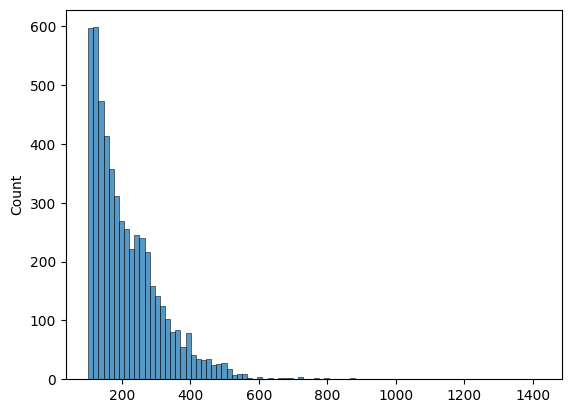

In [16]:
sns.histplot(lengths)

In [17]:
sequences[100]

['d3elka',
 'TRERILHGLITLYILKELVKRPHGYELQKSFETTGQALPQGSIYILLKTKERGFVISESSVNKGQQLTVYHITDAGKKFLDHSQALQLARKIIDDLLSTVD',
 '---HHHHHHHHHHHHHHHHH---HHHHHHHHH---------HHHHHHHHHHH---------------------HHHHHHH----HHHHHHHHHHHHHH---']

In [329]:
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

amino_acids = list(d.values())

amino_to_int_dict = {i:idx+3 for idx,i in enumerate(amino_acids)}
amino_to_int_dict["<PAD>"] = 0
amino_to_int_dict["<MASK>"] = 1
amino_to_int_dict["<END>"] = 0
int_to_amino_dict = {v:k for v,k in amino_to_int_dict.items()}

secondary_to_int_dict = {"<PAD>":2,"-":0,"H":1,"<END>":0}
int_to_secondary_dict = {v:k for v,k in secondary_to_int_dict.items()}

In [330]:
def tokenize_from_dict(sequence,tokenizer_dict,length=None):

	if length is None:
		length = len(sequence)

	seq = []

	for i in range(length):

		if i>len(sequence):
			seq.append(tokenizer_dict["<PAD>"])
		elif i == len(sequence):
			seq.append(tokenizer_dict["<END>"])
		else:
			seq.append(tokenizer_dict[sequence[i]])

	return jnp.array(seq)


In [331]:
inputs = []
labels = []

l_max = 384

for seq in sequences:
	if len(seq[1])<=l_max-1:
		inputs.append(tokenize_from_dict(seq[1],amino_to_int_dict,l_max))
		labels.append(tokenize_from_dict(seq[2],secondary_to_int_dict,l_max))

In [332]:
def get_xy(sequences,l_max):

	inputs = []
	labels = []

	for seq in sequences:
		if len(seq[1])<=l_max-1:
			inputs.append(tokenize_from_dict(seq[1],amino_to_int_dict,l_max))
			labels.append(tokenize_from_dict(seq[2],secondary_to_int_dict,l_max))

	return jnp.stack(inputs),jnp.stack(labels)

In [333]:
inputs,labels = get_xy(sequences,384)

In [334]:
print(inputs.shape)
print(labels.shape)

(4934, 384)
(4934, 384)


In [335]:
class FactorizedConv(nn.Module):
	feature:int
	kernel_size:int

	@nn.compact
	def __call__(self,x):
		x = nn.Dense(self.feature)(x)
		x = nn.Conv(self.feature,self.kernel_size,feature_group_count=self.feature)(x)
		return x

In [336]:
class MLP(nn.Module):
	features: Sequence[int]

	@nn.compact
	def __call__(self,x):
		for feature in self.features[:-1]:
			x = nn.relu(FactorizedConv(feature,3)(x))
		x = FactorizedConv(self.features[-1],3)(x)
		x = nn.LayerNorm()(x)
		return x

In [337]:
def sin_pos_encode(x):
	embeddings = jnp.zeros((x.shape))
	batch,length,dim = x.shape
	position = jnp.arange(0,length)
	omega = jnp.exp(jnp.arange(0,dim,2) * math.log(10000)/dim)
	embeddings = embeddings.at[:,:,0::2].set(jnp.sin(einx.multiply("l,d -> l d",position,omega)))
	embeddings = embeddings.at[:,:,1::2].set(jnp.cos(einx.multiply("l,d -> l d",position,omega)))

	return embeddings + x


In [338]:
512*5000

2560000

In [339]:
class MaskedMHA(nn.Module):
	hidden_dim:int
	heads:int

	@nn.compact
	def __call__(self,x,mask):

		q = nn.Dense(self.hidden_dim)(x)

		q = q * ((q.shape[-1] // self.heads) ** -0.5)
		attn = einx.dot("b q (h c), b k (h c) -> b q k h", q, x, h=self.heads)

		attn = einx.where("b k, b q k h,", mask, attn, -jnp.inf)

		attn = einx.softmax("b q [k] h", attn)
		y = einx.dot("b q k h, b k (h c) -> b q (h c)", attn, x)

		return x + y
		

In [410]:
class EncoderBlock(nn.Module):
	hidden_dim:int
	heads:int
	expansion_factor:int

	@nn.compact
	def __call__(self,x,mask):

		#x = x + nn.LayerNorm()(MaskedMHA(hidden_dim=self.hidden_dim,heads=self.heads)(x,mask))
		x = x + nn.LayerNorm()(MLP([self.hidden_dim*self.expansion_factor,self.hidden_dim])(x))
		return x

In [411]:
class Transformer(nn.Module):
	n_amino:int
	amino_dim:int
	n_heads:int
	n_layers:int
	expansion_factor:int

	@nn.compact
	def __call__(self,x,mask):
		x = nn.Embed(self.n_amino,self.amino_dim)(x)
		x = x + sin_pos_encode(x)

		for _ in range(self.n_layers):
			x = EncoderBlock(self.amino_dim,self.n_heads,self.expansion_factor)(x,mask)

		return x

In [412]:
class MaskedLM(nn.Module):
	n_amino:int
	amino_dim:int
	n_heads:int
	n_layers:int
	expansion_factor:int

	def setup(self):

		self.transformer = Transformer(n_amino=self.n_amino,
								 amino_dim=self.amino_dim,
								 n_heads=self.n_heads,
								 n_layers=self.n_layers,
								 expansion_factor=self.expansion_factor)
		
		self.layer_norm = nn.LayerNorm()
		self.masked_lm_head = nn.Dense(self.n_amino)
		self.structure_head = nn.Dense(2)

	def __call__(self,x,mask):

		x = self.transformer(x,mask)
		x = self.layer_norm(x)
		return x
	
	def lm_forward(self,x,mask):
		x = self(x,mask)
		return self.masked_lm_head(x)
	
	def structure_forward(self,x,mask):
		x = self(x,mask)
		return self.structure_head(x)

In [413]:
def mask_from_list(x,values):

	mask = jnp.zeros_like(x,dtype=jnp.bool)

	for i in values:
		mask += (x == i)

	return mask

In [414]:
len(amino_to_int_dict)

23

In [415]:
key = jax.random.key(0)

In [416]:
model = MaskedLM(n_amino=len(amino_to_int_dict),
					amino_dim=32,
					n_heads=2,
					n_layers=6,
					expansion_factor=2)

In [417]:
batch = jnp.ones((16,256),dtype=jnp.int32)
model_var = model.init(key,batch,mask_from_list(batch,[0]),method="structure_forward")

In [418]:
print(nn.tabulate(model,key)(inputs[0:2],mask_from_list(inputs[0:2],[0,1,2])))


                               MaskedLM Summary                                
┌───────────────┬──────────────┬───────────────┬──────────────┬───────────────┐
│ path          │ module       │ inputs        │ outputs      │ params        │
├───────────────┼──────────────┼───────────────┼──────────────┼───────────────┤
│               │ MaskedLM     │ -             │ float32[2,3… │               │
│               │              │ int32[2,384]  │              │               │
│               │              │ - bool[2,384] │              │               │
├───────────────┼──────────────┼───────────────┼──────────────┼───────────────┤
│ transformer   │ Transformer  │ -             │ float32[2,3… │               │
│               │              │ int32[2,384]  │              │               │
│               │              │ - bool[2,384] │              │               │
├───────────────┼──────────────┼───────────────┼──────────────┼───────────────┤
│ transformer/… │ Embed        │ int32[

In [419]:
inputs.shape

(4934, 384)

In [420]:
labels.shape

(4934, 384)

In [421]:
def masked_cross_entropy_loss(logits, labels, mask):
    loss = optax.softmax_cross_entropy(logits, one_hot(labels, logits.shape[-1]))
    masked_loss = loss * mask
    return jnp.sum(masked_loss) / jnp.sum(mask)

def one_hot(x, num_classes):
    return jnp.eye(num_classes)[x]


In [422]:
x = inputs[0:5]
y = labels[0:5]
mask = mask_from_list(x,[0])

In [423]:
def loss_fn(vars,x,mask,y,pred_mask):

	y_pred = model.apply(vars,x,mask,method=MaskedLM.structure_forward)
	loss = masked_cross_entropy_loss(y_pred,y,pred_mask)
	return loss

In [424]:
model.apply(model_var,x,mask,method="structure_forward").shape

(5, 384, 2)

In [425]:
loss_fn(model_var,x,mask,y,jnp.logical_not(mask)).item()

0.7075600028038025

In [428]:

def masked_accuracy(logits, labels, mask):
    predictions = jnp.argmax(logits, axis=-1)
    correct_predictions = (predictions == labels) * mask
    accuracy = jnp.sum(correct_predictions) / jnp.sum(mask)
    return accuracy


In [431]:
def custom_train(model,
				 key,
				 model_var,
				 x,
				 y,
				 batch_size,
				 forward,
				 n_epochs):
	
	def loss_fn(vars,x,mask,y,pred_mask):

		y_pred = model.apply(vars,x,mask,method=MaskedLM.structure_forward)
		loss = masked_cross_entropy_loss(y_pred,y,pred_mask)
		acc = masked_accuracy(y_pred,y,pred_mask)
		return loss,(acc)
	
	optimizer = optax.adam(1E-3)
	opt_state = optimizer.init(model_var)
	loss_grad_fn = jax.value_and_grad(loss_fn,has_aux=True)
	loss_grad_fn = jax.jit(loss_grad_fn)

	for epoch in range(n_epochs):

		permutations = random.permutation(key,jnp.arange(len(x)))
		permutations = permutations[0:batch_size*(len(x)//batch_size)]
		batches = einx.rearrange("(n b) -> n b",permutations,b=batch_size)

		losses = []

		for b,indices in enumerate(batches):

			x_batch = x[indices]
			y_batch = y[indices]

			pad_mask = mask_from_list(x_batch,[0,1])

			masked = random.uniform(key,x_batch.shape) > 0.9
			masked = jnp.logical_and(masked,jnp.logical_not(pad_mask))

			(loss,(acc)),grad = loss_grad_fn(model_var,x_batch,pad_mask,y_batch,masked)

			updates,opt_state = optimizer.update(grad,opt_state)
			model_var = optax.apply_updates(model_var,updates)
			losses.append(loss.item())

			if b % 10 == 0:
				print(acc)

		print(np.mean(losses))


In [432]:
custom_train(model,
			 key,
			 model_var,
			 inputs,
			 labels,
			 32,
			 MaskedLM.structure_forward,
			 10)

0.42541435
0.56122446
0.6231648
0.6101695
0.60600704
0.6003788
0.57385397
0.60847455
0.6630934
0.63205826
0.6378378
0.6606607
0.7138211
0.627907
0.68485916
0.7207703
0.6443745946729338
0.72007364
0.75
0.7161501
0.7016949
0.6819788
0.7462121
0.68930393
0.73050845
0.67381316
0.7140255
0.7279279
0.6996997
0.7398374
0.6976744
0.7253521
0.738652
0.5548894178944749
0.7495396
0.77040815
0.7471452
0.75084746
0.69787985
0.7613636
0.69949067
0.73220336
0.68147016
0.72313297
0.73333335
0.7117117
0.75609756
0.71594685
0.7429578
0.74965614
0.539179409479166
0.74401474
0.7823129
0.75203913
0.75932205


KeyboardInterrupt: 

In [394]:
random.uniform(key,x.shape)>0.9

Array([[False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]], dtype=bool)

- We first have to worry about processing
1. We need to get the data into lists of tuples (sequence,length,labels)
2. We tokenize the sequences and binarize the labels
3. We construct (tokenized) input/output sequences with maximum length
4. Probably select a cutoff length
   - let's say 512

- Once we have the inputs and output pairs we can move into training
- Implementing the neural network is trivial and independent of the task
- Afterwards, there are two ways of training the neural network
  - direct supervised training
  - masked language modeling - as you would with AlphaFold,ESMFold,... - followed by supervised training
  - this is a cute blog post

- There are "only" like 5000 sequences which may be somewhat small for deep-learning applications (unclear with masked modeling?)
  - in any case, we may want to perform data augmentation by randomly switching similar amino-acids together?
  - the other option would be to reduce the dictionnary size?
    - I feel like having augmentations would have the same effect as restricting the dictionnary